In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
# Easy way to set up device throughout your notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Tensors

In [ ]:
# Docs: https://pytorch.org/docs/stable/tensors.html\

x = torch.tensor([[i for i in range(28)] for _ in range(28)])
# Use view for easy reshaping, (there are other functions like squeeze too)
# Look at docs above

x.view(-1, 784)

a = torch.tensor([1,0])
b = torch.tensor([0,1])
print(a @ b)

c = torch.tensor([[1,2,3], [4,5,6]])

print(c[1][1])
print(c[1][1].item())

{'1': c}

tensor(0)
tensor(5)
5


{'1': tensor([[1, 2, 3],
         [4, 5, 6]])}

# Datasets and Dataloaders

With almost any form of data worth feeding a neural network, preprocessing is essential. PyTorch handles this with an object it calls the "Dataset" 


Later in this tutorial, we'll see how to build your own dataset. For now, we'll use one of their provided datasets so we can examine the objects torch provides.

There are a huge number of these datasets: ideal for playing around with different models: [torchvision.datasets — Torchvision 0.11.0 documentation](https://pytorch.org/vision/stable/datasets.html).

In [ ]:
from torch.utils.data import Dataset 
from torchvision import datasets 
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_data[0] 


(<PIL.Image.Image image mode=L size=28x28 at 0x7F199B868C90>, 9)

Ah! This has given us image objects. But our network doesn't understand PIL images!

This is where the small library of Pytorch "transforms" comes in handy.

In [ ]:
from PIL import Image 
train_data[0][0].show() 


In [ ]:
from torchvision.transforms import ToTensor 


Here's what it does: 


In [ ]:
trans = ToTensor() 
img = trans(train_data[0][0]) 


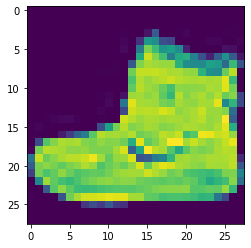

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze())

In [ ]:
train_data = datasets.FashionMNIST( 
    root = "data", 
    train = True, 
    download = True, 
    transform = ToTensor() 
) 
test_data = datasets.FashionMNIST( 
    root = "data", 
    train = False, 
    download = True, 
    transform = ToTensor() 
) 
                                        

In [ ]:
print("training data length:", len(train_data)) 
print("test data length:", len(train_data)) 


training data length: 60000
test data length: 60000


In [ ]:
img = train_data[0][0] 
img.shape 

torch.Size([1, 28, 28])

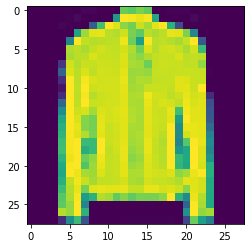

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
rand = np.random.randint(len(train_data)) 
plt.imshow(train_data[rand][0].squeeze()) 


## Let there be dataloaders!

In [ ]:
from torch.utils.data import DataLoader 
train_loader = DataLoader(train_data, batch_size = 16, shuffle=True) 
test_loader = DataLoader(test_data, batch_size = len(train_data), shuffle=True) 


What is this thing? 
On the most basic level, it's designed to be iterated! 

In [ ]:
for x, label in train_loader: 
    print("Image shape is ",x.shape) 
    print("Labels shape is ",label.shape) 
    break 
              

Image shape is  torch.Size([16, 1, 28, 28])
Labels shape is  torch.Size([16])


This tells us that we have to resize the images once more, to flatten them into single-dimensional tensors.

In [ ]:
for x, label in train_loader:
    x = x.reshape(-1,28*28)
    print("Image shape is ",x.shape)
    print("Labels shape is ",label.shape)
    break

Image shape is  torch.Size([16, 784])
Labels shape is  torch.Size([16])


# Simple Model Creation

In [ ]:
# Two Ways, both of them do the exact same thing
class BasicNeuralNet1(nn.Module):
  def __init__(self):
    super(BasicNeuralNet1, self).__init__()
    self.layer1 = nn.Linear(784, 256)
    self.layer2 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 784)
    x = F.sigmoid(self.layer1(x))
    x = self.layer2(x)
    return F.log_softmax(x)

class BasicNeuralNet2(nn.Module):
  def __init__(self):
    super(BasicNeuralNet2, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(784, 256),
        nn.Sigmoid(),
    )

    self.layer2 = nn.Sequential(
        nn.Linear(256, 10),
        nn.LogSoftmax(),
    )

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.layer1(x)
    return self.layer2(x)

# Train that Model! (The two key pieces)

The two fundamental things here are the *loss function* and the *optimizer*. PyTorch has an extensive library with many different loss functions and optimizers.

It's traditional to have a big list of hyperparameters

In [ ]:
model = BasicNeuralNet1()
learning_rate = 0.05
epochs = 10
MSELoss = torch.nn.MSELoss()
CELoss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

It's also good to define a test/accuracy function, to keep tabs on how the model is doing

In [ ]:
def get_accuracy(output, targets): 
    """calculates accuracy from model output and targets 
    """ 
    output = output.detach() 
    predicted = output.argmax(-1) 
    correct = (predicted == targets).sum().item() 
    accuracy = correct / output.size(0) * 100 
    return accuracy 
                              

This is a very handy function for visualizing progress. It acts just like the normal python "range", except it displays a progress bar.

In [ ]:
from tqdm.notebook import trange

And then it all comes together:

In [ ]:
for epoch in trange(epochs): 
    model.train()
    for data, labels in train_loader: 
        # clear out the gradients before doing the forward and backward pass 
        optimizer.zero_grad() 
        # run data through model 
        preds = model(data) 
        # compare predictions to actual labels 
        loss = CELoss(preds,labels) 
        # Backpropogate the loss 
        loss.backward() 
        # Adjust the model parameters via the optimizer 
        optimizer.step() 
    # After each epoch, it's nice to see how our model is doing 
    model.eval() # disables gradient computations 
    test_data, test_labels = next(iter(test_loader)) 
    test_data = test_data.reshape(-1,784) 
    test_preds = model(test_data) 
    test_acc = get_accuracy(test_preds,test_labels) 
    train_acc = get_accuracy(preds, labels) 
    print(f"Epoch {epoch}. Train Acc {train_acc}% | Test Acc {test_acc}") 


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch 0. Train Acc 81.25% | Test Acc 64.24
Epoch 1. Train Acc 75.0% | Test Acc 58.68
Epoch 2. Train Acc 75.0% | Test Acc 71.3
Epoch 3. Train Acc 56.25% | Test Acc 65.95
Epoch 4. Train Acc 62.5% | Test Acc 66.83
Epoch 5. Train Acc 81.25% | Test Acc 65.41
Epoch 6. Train Acc 93.75% | Test Acc 63.580000000000005
Epoch 7. Train Acc 56.25% | Test Acc 70.48
Epoch 8. Train Acc 75.0% | Test Acc 65.14
Epoch 9. Train Acc 81.25% | Test Acc 72.25


# More Dataloaders

Probably more important for project, and you probably won't ever need it, but heres an example to show you a little about a custom dataloader could be implemented

In [ ]:
# class ModelData(Dataset):
#   def __init__(self, folder_name):
#     self.csv_path = f"/content/gdrive/MyDrive/TrainingData/NewData/{folder_name}/vectors.csv"
#     self.vectors = pd.read_csv(self.csv_path, header=None )
#     #self.normalize()
#     self.vectors_ = torch.from_numpy(self.vectors.values)
#     self.img_dir = f"/content/gdrive/MyDrive/TrainingData/NewData/{folder_name}" 
  
#   # Normalize the position parts of the desired output to allow our network
#   # to be trained more easily
#   def normalize(self):
#     scaler = preprocessing.MinMaxScaler()
#     self.vectors.iloc[ : , 50: 150] = scaler.fit_transform(self.vectors.iloc[ : , 50: 150])
#     self.vectors.iloc[ : , 150:152] = scaler.fit_transform(self.vectors.iloc[ : , 150:152])
#     self.vectors.iloc[ : , 202:302] = scaler.fit_transform(self.vectors.iloc[ : , 202:302])
#     self.vectors.iloc[: , 302:304] = scaler.fit_transform(self.vectors.iloc[ : , 302:304])
#     self.vectors.iloc[ : , 354:454] = scaler.fit_transform(self.vectors.iloc[ : , 354:454])
#     self.vectors.iloc[ : , 454:456] = scaler.fit_transform(self.vectors.iloc[ : , 454:456])
  
#   # Return the length of the dataset
#   def __len__(self):
#     return self.vectors.shape[0]
  
#   # Load an image from google drive and transform it to something usable
#   def get_image(self, index):
#     image = Image.open(os.path.join(self.img_dir, f"out{index}.png"))
#     image = image.convert('L')
#     image = PIL.ImageOps.invert(image)
#     image = np.array(image)
#     image = torch.from_numpy(image)
#     image = image.data.to(dtype=torch.float32)
#     return image

#   # Get an item
#   def __getitem__(self, index):
#     img = self.get_image(index)
#     vector = self.vectors.iloc[index]
#     return (img,torch.tensor(vector, dtype=torch.float32))

# # Load Data
# test_dataset = ModelData("Batch1")
# train_dataset1 = ModelData("Batch2")
# train_dataset2 = ModelData("Batch3")

# # Concatenate two folders to create a larger dataset for training
# train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])

# # Create the train loader with batch size 64
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=64, 
#     shuffle=True,
# )

# # Create the test loader with batch size 32
# test_loader = torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size = 32, 
#     shuffle=True
# )

# Making Fancier Models

# Strategies for Hyperparameter Tuning

# Colab CUDA

Make sure to have both tensors on the same device

In [ ]:
data = torch.tensor([i for i in range(5)])
err_data = torch.tensor([i for i in range(5)])
err_data = err_data.to(torch.device("cpu"))
data = data.to(device)

In [ ]:
print(data.device)
print(err_data.device)

print(data @ err_data)


cuda:0
cpu


RuntimeError: ignored

# Cluster CUDA tricks